In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import wandb
import os, sys
import glob
import numpy as np
import torch
import pandas as pd
import random
import torch.nn as nn
import pickle
import torch.nn.functional as F

In [3]:
from model import C2F_TCN
from dataset import AugmentDataset, collate_fn_override
from utils import calculate_mof, dotdict

In [4]:
os.environ["WANDB_API_KEY"] = "992b3b1371ba79f48484cfca522b3786d7fa52c2"
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: dipika_singhania (use `wandb login --relogin` to force relogin)


True

In [5]:
seed = 42

# Ensure deterministic behavior
def set_seed():
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
set_seed()

# Device configuration
os.environ['CUDA_VISIBLE_DEVICES']='7'
# os.environ['CUDA_LAUNCH_BLOCKING']='6'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
config = dotdict(
    epochs=500,
    num_class=48,
    batch_size=50,
    learning_rate=1e-4,
    weight_decay=3e-3,
    dataset="Breakfast",
    architecture="unet-ensemble",
    features_file_name="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/features/",
    chunk_size=10,
    max_frames_per_video=1200,
    feature_size=2048,
    ground_truth_files_dir="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/groundTruth/",
    label_id_csv="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/mapping.csv",
    gamma=0.1,
    step_size=500,
    split=2,
#     output_dir="/mnt/data/ar-datasets/dipika/breakfast/ms_tcn/data/breakfast/results/unsuper-finetune-split2-0.05-data-llr/",
    output_dir="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-maximize/",
    project_name="breakfast-split-2",
    train_split_file="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/train.split{}.bundle",
    test_split_file="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/test.split{}.bundle",
    all_files="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/all_files.txt",
    cutoff=8,
    data_per = 0.2,
    budget=40,
    semi_supervised_split="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/semi_supervised/train.split{}_amt{}.bundle")

config.train_split_file = config.train_split_file.format(config.split)
config.semi_supervised_split = config.semi_supervised_split.format(config.split, config.data_per)
config.test_split_file = config.test_split_file.format(config.split)

if not os.path.exists(config.output_dir):
    os.mkdir(config.output_dir)

print(config)

{'epochs': 500, 'num_class': 48, 'batch_size': 50, 'learning_rate': 0.0001, 'weight_decay': 0.003, 'dataset': 'Breakfast', 'architecture': 'unet-ensemble', 'features_file_name': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/features/', 'chunk_size': 10, 'max_frames_per_video': 1200, 'feature_size': 2048, 'ground_truth_files_dir': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/groundTruth/', 'label_id_csv': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/mapping.csv', 'gamma': 0.1, 'step_size': 500, 'split': 2, 'output_dir': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-maximize/', 'project_name': 'breakfast-split-2', 'train_split_file': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/train.split2.bundle', 'test_split_file': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/test.split2.bundle', 'all_files': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/all_files.txt', 'cutoff': 8, 'data_per': 0.2, 'budget': 40, 'semi_supervised_split': '/mnt/

In [7]:
traindataset = AugmentDataset(config, fold='train', fold_file_name=config.semi_supervised_split, augment=False)

Number of videos logged in train fold is 257
Number of videos not found in train fold is 0


In [8]:
def _init_fn(worker_id):
    np.random.seed(int(seed))
trainloader = torch.utils.data.DataLoader(dataset=traindataset,
                                          batch_size=config.batch_size, 
                                          shuffle=True,
                                          pin_memory=True, num_workers=7, collate_fn=collate_fn_override,
                                          worker_init_fn=_init_fn)

In [9]:
# item = iter(trainloader).next()
# print(item[0]) # -- data feature
# print(item[1]) # -- valid count
# item[2] # -- Actual labels
# print(item[5]) # video names
# video_id_boundary_frames

In [10]:
loaded_vidid_selected_frames = pickle.load(open("dump_dir/loaded_vidid_selected_frames_dict.pkl", "rb"))
# loaded_vidid_selected_frames

In [11]:
video_id_boundary_frames = pickle.load(open("dump_dir/video_id_boundary_frames_dict.pkl", "rb"))
# video_id_boundary_frames

In [12]:
prob_video_each_segment_dict = {}

In [13]:
def prob_vals_per_segment(selected_frames, cur_vid_feat, labels):
    prob_each_segment = []
    
    log_probs = torch.log(cur_vid_feat + 1e-8)
    cumsum_feat = torch.cumsum(log_probs, dim=0)
        
    for i, cur_ele in enumerate(selected_frames[:-1]):
        
        next_ele = selected_frames[i + 1]
        label_cur_ele = labels[cur_ele]
        label_next_ele = labels[next_ele]
        prob_list = []
        for ele in range(cur_ele, next_ele, 1):
            start_sum = cumsum_feat[cur_ele - 1, :] if cur_ele > 0 else 0
            sum_window_class_1 = (cumsum_feat[ele, :] - start_sum)[label_cur_ele]
            sum_window_class_2 = (cumsum_feat[next_ele - 1, :] - cumsum_feat[ele, :])[label_next_ele]
            prob_list.append((sum_window_class_1 + sum_window_class_2))
            
        prob_list = torch.softmax(torch.stack(prob_list), dim=0)
        prob_each_segment.append(prob_list)
    
    return prob_each_segment

In [14]:
# selected_frames = torch.tensor([2, 10, 17, 21])
# cur_vid_feat = torch.randn((27, 48))
# labels = torch.tensor([47, 47, 47, 47, 47, 4, 4, 4, 4, 4, 4, 4, 8, 8, 8, 8, 8, 8, 8, 8, 10, 10, 10, 10, 10, 10, 10])
# # print(len(labels))
# probs_all_segs = prob_vals_per_segment(selected_frames, cur_vid_feat, labels)
# print(probs_all_segs)

In [15]:
def calculate_element_probb(data_feat, data_count, video_ids, labels_all): #, loaded_vidid_selected_frames, boundaries_dict):
    global prob_video_each_segment_dict, loaded_vidid_selected_frames
    for iter_num in range(len(data_count)):
        cur_vidid = video_ids[iter_num]
        cur_vid_feat = data_feat[iter_num]
        cur_vid_count = data_count[iter_num]
        labels = labels_all[iter_num]
        
        selected_frames = loaded_vidid_selected_frames[cur_vidid]
        prob_video = prob_vals_per_segment(selected_frames, cur_vid_feat, labels)
        prob_video_each_segment_dict[cur_vidid] = prob_video

In [16]:
def get_estimated_loss(data_feat, data_count, video_ids, labels_all): #, loaded_vidid_selected_frames, boundaries_dict):
    global prob_video_each_segment_dict, loaded_vidid_selected_frames
    loss_arr = []
    for iter_num in range(len(data_count)):
        cur_vidid = video_ids[iter_num]
        cur_vid_feat = data_feat[iter_num]
        cur_vid_count = data_count[iter_num]
        labels = labels_all[iter_num]
        
        selected_frames = loaded_vidid_selected_frames[cur_vidid]
        prob_each_video = prob_video_each_segment_dict[cur_vidid]
        
        log_probs = torch.log(cur_vid_feat + 1e-8)
        cumsum_feat = torch.cumsum(log_probs, dim=0)
        
        
        current_vid_prob_arr = []
        # Start segment log probability
        start_ele_idx = selected_frames[0]
        if start_ele_idx > 0:
            start_ele_label_idx = labels[selected_frames[0]]
            first_segment_prob = (cumsum_feat[start_ele_idx - 1, :])[start_ele_label_idx]
            current_vid_prob_arr.append(first_segment_prob)
        
        for i, cur_ele in enumerate(selected_frames[:-1]):
            next_ele = selected_frames[i + 1]
            label_cur_ele = labels[cur_ele]
            label_next_ele = labels[next_ele]

            count = 0
            for ele in range(cur_ele, next_ele, 1):
                start_sum = cumsum_feat[cur_ele - 1, :] if cur_ele > 0 else 0
                sum_window_class_1 = (cumsum_feat[ele, :] - start_sum)[label_cur_ele]
                sum_window_class_2 = (cumsum_feat[next_ele - 1, :] - cumsum_feat[ele, :])[label_next_ele]
                current_vid_prob_arr.append((sum_window_class_1 + sum_window_class_2)  * (prob_each_video[i][count].item()))
                count = count + 1
        
        # End segment log probability
        end_index = cur_vid_count.item() - 1
        last_ele_label_idx = labels[selected_frames[-1]]
        last_segment_sum_prob = (cumsum_feat[end_index, :] - cumsum_feat[selected_frames[-1] - 1, :])[last_ele_label_idx]
        current_vid_prob_arr.append(last_segment_sum_prob)
            
        loss_arr.append(torch.stack(current_vid_prob_arr))
    return -torch.mean(torch.cat(loss_arr)), loss_arr
#     return loss_arr

In [17]:
def get_estimated_boundaries():
    global prob_video_each_segment_dict, loaded_vidid_selected_frames, video_id_boundary_frames
    estimated_boundary_dict = {}
    for ele in video_id_boundary_frames.keys():
        
        estimated_boundary_probs = prob_video_each_segment_dict[ele]
        selected_ele_list = loaded_vidid_selected_frames[ele]
        boundary_list = []
        for i, segment in enumerate(estimated_boundary_probs):
            estimated_boundary = np.sum(np.arange(selected_ele_list[i], selected_ele_list[i + 1], 1) \
                                        * segment.detach().cpu().numpy())
            estimated_boundary = int(estimated_boundary.item() + 1e-5)
            
            if (estimated_boundary < selected_ele_list[i]) or (estimated_boundary > selected_ele_list[i + 1]):
                print("Estimated value wrong")
                import pdb
                pdb.set_trace()
            boundary_list.append(estimated_boundary)

        estimated_boundary_dict[ele] = boundary_list
    return estimated_boundary_dict

In [18]:
def get_boundary_err():
    global prob_video_each_segment_dict, loaded_vidid_selected_frames
    err_list = []
    correct = 0.0
    total = 0.0
    estimated_boundar_dict = get_estimated_boundaries()
    for ele in video_id_boundary_frames.keys():
        
        estimated_boundary_probs = prob_video_each_segment_dict[ele]
        estimated_boundary_list = estimated_boundar_dict[ele]
        
        estimated = np.array(estimated_boundary_list) #.detach().cpu().numpy()
        actual = np.array(video_id_boundary_frames[ele][:-1])
        if len(actual) != len(estimated):
            print(ele)
            continue
        
        mse_err = (actual - estimated)**2
        err_list.append(mse_err)
        
        estimated_labels = []
        actual_labels = []
        start_v1 = 0
        start_v2 = 0
        for i, v1 in enumerate(estimated):
            estimated_labels.extend([i] * (v1 - start_v1))
            start_v1 = v1
            v2 = actual[i]
            actual_labels.extend([i] * (v2 - start_v2))
            start_v2 = v2
            
        last_ele = video_id_boundary_frames[ele][-1]
        estimated_labels.extend([i+1] * (last_ele - start_v1))
        actual_labels.extend([i+1] * (last_ele - start_v2))
        
        correct += np.sum(np.array(actual_labels) == np.array(estimated_labels))
        total += len(actual_labels)
        
    print(f"Boundary avergage error = {np.sqrt(np.mean(np.concatenate(err_list))):.3f}")
    print(f"From boundary avergage accuracy = {correct * 100.0 / total:.3f}")


In [19]:
set_seed()
model = C2F_TCN(n_channels=config.feature_size, n_classes=config.num_class).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=3e-3)

# Requires loaded_vidid_selected_frames, boundaries_dict
cos = nn.CosineSimilarity(dim=1, eps=1e-6)
ce_criterion = nn.CrossEntropyLoss(ignore_index=-100)
mse_criterion = nn.MSELoss(reduction='none')

In [20]:
for epoch in range(2000):
    if epoch % 20 == 0:
        model.eval()
        print("Calculating Expectation")
        correct = 0.0
        total = 0.0
        for i, item in enumerate(trainloader):
            with torch.no_grad():
                item[0] = item[0].to(device)
                item[1] = item[1].to(device)
                item[2] = item[2].to(device)
                y, _, features = model(item[0].permute(0,2,1))
                prob = torch.softmax(y, dim=1)
                prob = prob.permute(0,2,1)
                calculate_element_probb(prob, item[1], item[5], item[2])
                
                src_mask = torch.arange(item[2].shape[1], device=item[2].device)[None, :] < item[1][:, None]
                pred = torch.argmax(prob, dim=2)
                correct += float(torch.sum((pred == item[2]) * src_mask).item())
                total += float(torch.sum(src_mask).item())
        print(f"Accuracy calculated with probabilities {correct * 100.0 / total: .3f}")
        get_boundary_err()
    model.train()
    print("Starting Maximization")
    for i, item in enumerate(trainloader):
        item[0] = item[0].to(device)
        item[1] = item[1].to(device)
        
        optimizer.zero_grad()
        y, _, features = model(item[0].permute(0,2,1))
        prob = torch.softmax(y, dim=1)
        prob = prob.permute(0,2,1)
        loss, _ = get_estimated_loss(prob, item[1], item[5], item[2].to(device))
        loss.backward()
        optimizer.step()
        if i%5==0:
            print(f"Current loss {loss.item()}")

Calculating Expectation


/home/dipika16/anaconda3/envs/video_r/lib/python3.7/site-packages/torch/nn/functional.py:2952: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Accuracy calculated with probabilities  4.331
Boundary avergage error = 25.967
From boundary avergage accuracy = 72.272
Starting Maximization
Current loss 4.494490146636963
Current loss 3.990020751953125
Starting Maximization
Current loss 3.4496347904205322
Current loss 3.318120002746582
Starting Maximization
Current loss 3.339700222015381
Current loss 3.1745240688323975
Starting Maximization
Current loss 2.8060801029205322
Current loss 2.8036012649536133
Starting Maximization
Current loss 2.793907403945923
Current loss 2.896103620529175
Starting Maximization
Current loss 2.406277656555176
Current loss 3.132328987121582
Starting Maximization
Current loss 2.1675148010253906
Current loss 2.7150490283966064
Starting Maximization
Current loss 2.012951374053955
Current loss 2.3352463245391846
Starting Maximization
Current loss 2.118556499481201
Current loss 2.6177589893341064
Starting Maximization
Current loss 1.961077332496643
Current loss 2.0752017498016357
Starting Maximization
Current l

Current loss 0.25533849000930786
Current loss 0.801825225353241
Starting Maximization
Current loss 0.24907559156417847
Current loss 0.5301936268806458
Starting Maximization
Current loss 0.2596633732318878
Current loss 0.6994645595550537
Starting Maximization
Current loss 0.21838192641735077
Current loss 0.4531419575214386
Starting Maximization
Current loss 0.2119472473859787
Current loss 0.3317258059978485
Starting Maximization
Current loss 0.2114890068769455
Current loss 0.32695472240448
Starting Maximization
Current loss 0.21251513063907623
Current loss 0.41449883580207825
Starting Maximization
Current loss 0.23351576924324036
Current loss 0.4815447926521301
Starting Maximization
Current loss 0.20313702523708344
Current loss 0.4030141830444336
Starting Maximization
Current loss 0.20874278247356415
Current loss 0.7844823598861694
Starting Maximization
Current loss 0.21900752186775208
Current loss 0.44344139099121094
Starting Maximization
Current loss 0.20541520416736603
Current loss 0

Current loss 0.15942732989788055
Current loss 0.29187363386154175
Starting Maximization
Current loss 0.2671394646167755
Current loss 0.3501001000404358
Starting Maximization
Current loss 0.16392214596271515
Current loss 0.2960975170135498
Starting Maximization
Current loss 0.14465798437595367
Current loss 0.33365127444267273
Calculating Expectation
Accuracy calculated with probabilities  69.843
Boundary avergage error = 23.535
From boundary avergage accuracy = 72.224
Starting Maximization
Current loss 0.12820930778980255
Current loss 0.5010755658149719
Starting Maximization
Current loss 0.13095463812351227
Current loss 1.9360158443450928
Starting Maximization
Current loss 0.15495926141738892
Current loss 0.41971829533576965
Starting Maximization
Current loss 0.1844165176153183
Current loss 0.29353585839271545
Starting Maximization
Current loss 0.20127779245376587
Current loss 0.5316897034645081
Starting Maximization
Current loss 0.13907720148563385
Current loss 0.21682296693325043
Star

Current loss 0.0893232673406601
Current loss 0.13249072432518005
Starting Maximization
Current loss 0.1200186163187027
Current loss 0.31393471360206604
Starting Maximization
Current loss 0.07908844947814941
Current loss 0.1776372194290161
Starting Maximization
Current loss 0.09160803258419037
Current loss 0.11447453498840332
Starting Maximization
Current loss 0.07439353317022324
Current loss 0.12699493765830994
Starting Maximization
Current loss 0.0852833092212677
Current loss 0.1501261442899704
Starting Maximization
Current loss 0.07572557777166367
Current loss 0.21132434904575348
Starting Maximization
Current loss 0.08000674098730087
Current loss 0.3169117271900177
Starting Maximization
Current loss 0.0779327005147934
Current loss 0.1910882592201233
Starting Maximization
Current loss 0.10560677200555801
Current loss 0.1806829571723938
Starting Maximization
Current loss 0.10452376306056976
Current loss 0.1769002079963684
Starting Maximization
Current loss 0.08599433302879333
Current l

KeyboardInterrupt: 

In [22]:
def get_selected_labels(labels_arr):
    unique_ids = []
    
    prev_ele = None
    start = 0
    for i, ele in enumerate(labels_arr):
        if prev_ele is not None and prev_ele != ele:
            select_item = np.random.randint(start, i, 1)[0]
            unique_ids.append(select_item)
            start = i
        prev_ele = ele
    
    select_item = np.random.randint(start, len(labels_arr), 1)[0]
    unique_ids.append(select_item)
    return unique_ids
# get_selected_labels(ab)

In [30]:
def get_boundary(labels_arr):
    unique_ids = []
    
    prev_ele = None
    start = 0
    for i, ele in enumerate(labels_arr):
        if prev_ele is not None and prev_ele != ele:
            unique_ids.append(i - 1)
            start = i
        prev_ele = ele
    
    unique_ids.append(len(labels_arr) - 1)
    return unique_ids
# get_boundary(np.array([2, 2, 2, 2, 3, 3, 4, 4, 4, 1, 1, 1, 1]))

In [29]:
loaded_vidid_selected_frames = {}
for batch in trainloader:
    count_all = batch[1]
    labels_all = batch[2]
    video_ids = batch[5]
    for i, count in enumerate(count_all):
        video_id = video_ids[i]
        labels = labels_all[i][:count]
        selected_ids = get_selected_labels(labels)

        loaded_vidid_selected_frames[video_id] = selected_ids

Traceback (most recent call last):
  File "/home/dipika16/anaconda3/envs/video_r/lib/python3.7/multiprocessing/queues.py", line 232, in _feed
    close()
  File "/home/dipika16/anaconda3/envs/video_r/lib/python3.7/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/home/dipika16/anaconda3/envs/video_r/lib/python3.7/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


In [14]:
video_id_boundary_frames = {}
for batch in trainloader:
    count_all = batch[1]
    labels_all = batch[2]
    video_ids = batch[5]
    for i, count in enumerate(count_all):
        
        labels = labels_all[i][:count]
        selected_ids = get_boundary(labels)
        video_id = video_ids[i]
        video_id_boundary_frames[video_id] = selected_ids

In [16]:
for ele in video_id_boundary_frames.keys():
    if len(video_id_boundary_frames[ele]) != len(loaded_vidid_selected_frames[ele]):
        print(ele)

In [15]:
import pickle
pickle.dump(video_id_boundary_frames, open("dump_dir/video_id_boundary_frames_dict.pkl", "wb"))
pickle.dump(loaded_vidid_selected_frames, open("dump_dir/loaded_vidid_selected_frames_dict.pkl", "wb"))

In [55]:
def get_ensemble_out(outp):
    
    weights = [1, 1, 1, 1, 0, 0]
    ensemble_prob = F.softmax(outp[0], dim=1) * weights[0] / sum(weights)

    for i, outp_ele in enumerate(outp[1]):
        upped_logit = F.upsample(outp_ele, size=outp[0].shape[-1], mode='linear', align_corners=True)
        ensemble_prob = ensemble_prob + F.softmax(upped_logit, dim=1) * weights[i + 1] / sum(weights)
    
    return ensemble_prob

In [56]:
model.load_state_dict(torch.load('/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/results/c2f-tcn-model/split2_c2ftcn_model.wt'))

<All keys matched successfully>

In [21]:
model.eval()
loss_arr = []
correct = 0.0
total = 0.0
for i, item in enumerate(trainloader):
    with torch.no_grad():
        item[0] = item[0].to(device)
        item[1] = item[1].to(device)
        y, y_list, _ = model(item[0].permute(0,2,1))
        prob = torch.softmax(y, dim=1).permute(0,2,1)
#         prob = get_ensemble_out([y, y_list]).permute(0,2,1)
        calculate_element_probb(prob, item[1], item[5], item[2].to(device))
        loss, _ = get_estimated_loss(prob, item[1], item[5], item[2].to(device))
        loss_arr.append(loss)
        
        estimated_labels = torch.argmax(prob, dim=2)
        correct += torch.sum(estimated_labels == )
#         probs = get_ensemble_out([y, y_list])
#         features = torch.log(probs + 1e-4).permute(0,2,1)
#         get_estimated_boundary(features, item[1], item[5])
get_boundary_err()
print("Average loss", torch.mean(torch.tensor(loss_arr)))

Boundary avergage error = 25.242
From boundary avergage accuracy = 69.543
tensor(0.4019)


In [22]:
for i in range(prob.shape[0]):
    loss_i, _ = get_estimated_loss(prob[i].unsqueeze(0), item[1][i].unsqueeze(0), [item[5][i]], item[2][i].unsqueeze(0))
    print(loss_i)
#     print(torch.mean(torch.cat(loss_i)))

tensor(0.4542, device='cuda:0')
tensor(0.1349, device='cuda:0')
tensor(1.5728, device='cuda:0')
tensor(0.6470, device='cuda:0')
tensor(0.2702, device='cuda:0')
tensor(0.5915, device='cuda:0')
tensor(2.8901, device='cuda:0')


In [65]:
loss_i

tensor(0.7432, device='cuda:0')

In [28]:
with torch.no_grad():
    idx = 6

    cur_vid_feat = prob[idx]
    cur_vidid = item[5][idx]
    labels = item[2][idx]
    selected_frames = torch.tensor(loaded_vidid_selected_frames[cur_vidid], dtype=torch.long, 
                                   device=cur_vid_feat.device)
    prob_each_segment = prob_vals_per_segment(selected_frames, cur_vid_feat, labels)

In [29]:
loss_i, _ = get_estimated_loss(prob[idx].unsqueeze(0), item[1][idx].unsqueeze(0), [item[5][idx]], item[2][idx].unsqueeze(0))

In [30]:
loss_i

tensor(2.8901, device='cuda:0')

(0, 1.2)

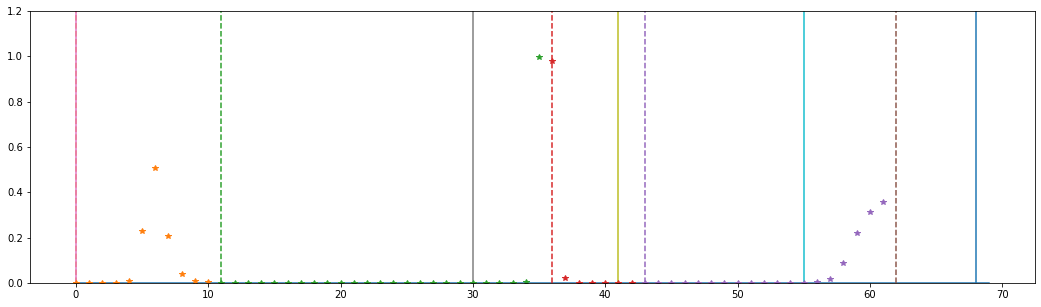

In [31]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(18, 5))

ymax = 1.2

plt.plot([0, item[1][idx].item()], [0, 0])

for pivot in loaded_vidid_selected_frames[cur_vidid]:
    plt.plot([pivot, pivot], [0, ymax], '--')
    
for pivot in video_id_boundary_frames[cur_vidid]:
    plt.plot([pivot, pivot], [0, ymax])
    
all_prob = []
for i, segment in enumerate(prob_each_segment):
#     all_prob.append(segment/torch.sum(segment))
    prob_i = segment / torch.sum(segment)
    prob_i = prob_i.cpu().numpy()
    xs = np.arange(loaded_vidid_selected_frames[cur_vidid][i], loaded_vidid_selected_frames[cur_vidid][i+1])
    plt.plot(xs, prob_i, '*')

plt.ylim([0, ymax])
# all_prob = torch.cat(all_prob).cpu().numpy()
# xs = np.arange(loaded_vidid_selected_frames[cur_vidid][0] + 1, loaded_vidid_selected_frames[cur_vidid][-1])
# plt.plot(xs, all_prob, '-')

In [80]:
cur_vid_feat = torch.softmax(y, dim=1).permute(0,2,1)[idx]
cur_vid_count = item[1][idx]
labels = item[2][idx]

selected_frames = loaded_vidid_selected_frames[cur_vidid]
prob_each_video = prob_video_each_segment_dict[cur_vidid]

log_probs = torch.log(cur_vid_feat + 1e-8)
cumsum_feat = torch.cumsum(log_probs, dim=0)

full_arr = []
for i, cur_ele in enumerate(selected_frames[:-1]):
    next_ele = selected_frames[i + 1]
    label_cur_ele = labels[cur_ele]
    label_next_ele = labels[next_ele]
    prob_list = [] 

    count = 0
    for ele in range(cur_ele, next_ele, 1):
        start_sum = cumsum_feat[cur_ele - 1, :] if cur_ele > 0 else 0
        sum_window_class_1 = (cumsum_feat[ele, :] - start_sum)[label_cur_ele]
        sum_window_class_2 = (cumsum_feat[next_ele - 1, :] - cumsum_feat[ele, :])[label_next_ele]
        prob_list.append((sum_window_class_1 + sum_window_class_2)  * (prob_each_video[i][count].item()))
        count = count + 1
    full_arr.append(torch.stack(prob_list))

In [81]:
-torch.mean(torch.cat(full_arr))

tensor(0.3756, device='cuda:0')

In [83]:
label_cur_ele

tensor(14)

In [84]:
label_next_ele

tensor(47)

In [85]:
selected_frames

[0, 10, 18, 60, 102, 183, 198, 242]

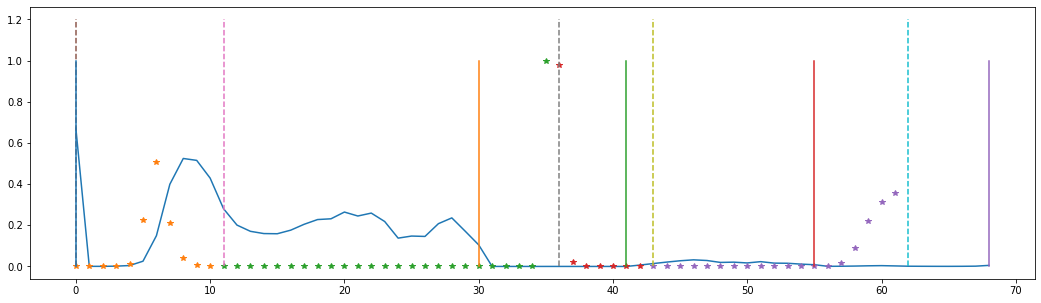

In [32]:
plt_arr = []


for i in range(item[1][idx].item()):
    plt_arr.append(cur_vid_feat[i,item[2][idx][i]].item()) 

fig = plt.figure(figsize=(18, 5))
plt.plot(np.arange(item[1][idx].item()), plt_arr)

all_prob = []
for i, segment in enumerate(prob_each_segment):
#     all_prob.append(segment/torch.sum(segment))
    prob_i = segment / torch.sum(segment)
    prob_i = prob_i.cpu().numpy()
    xs = np.arange(loaded_vidid_selected_frames[cur_vidid][i], loaded_vidid_selected_frames[cur_vidid][i+1])
    plt.plot(xs, prob_i, '*')

for pivot in loaded_vidid_selected_frames[cur_vidid]:
    plt.plot([pivot, pivot], [0, ymax], '--')
    
for pivot in video_id_boundary_frames[cur_vidid]:
    plt.plot([pivot, pivot], [0, 1])